In [1]:
import itertools
import matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tqdm import tqdm
from scipy.spatial import distance

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
np.random.seed(0)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y_train = np.argmax(y_train, axis=1)

order = np.random.permutation(len(x_train))

x_train = x_train[order]
y_train = y_train[order]


y_train = tf.keras.utils.to_categorical(y_train, 10)

x_train_reshape = [x_train[i].reshape((784)) for i in range(len(x_train))]
print(np.array(x_train_reshape).shape)

(60000, 784)


In [5]:
n_hidden_neurons = 64
lr = 0.001
epochs = 200
batch_size = 8
limit = 4096 # number of training examples to use.
alpha = 1.0 # penalise polysemantic neurons

In [6]:
i = tf.keras.layers.Input(shape=(28*28,))
i2 = tf.keras.layers.Input(shape=(10,))
e = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_1')(i)
o = tf.keras.layers.Dense(10, activation='softmax', name='softmax')(e)
model = tf.keras.Model(inputs=[i, i2], outputs=o)

2022-05-18 07:23:09.789366: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-18 07:23:09.802910: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fedd4415b80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-18 07:23:09.802926: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


### define polysemantic loss

In [7]:
def calculate_term(e, c0, c1):
  a = K.expand_dims(e[c0] / (K.max(K.abs(e[c0])) + 1e-9))
  b = K.expand_dims(e[c1] / (K.max(K.abs(e[c1])) + 1e-9))
  return K.dot(K.transpose(a), b)

In [8]:
#https://stackoverflow.com/questions/62454500/how-to-use-tensorflow-custom-loss-for-a-keras-model
def my_loss(y_true, y_pred, e, c0, c1, alpha):
    p_loss = 0
    for i in range(len(c0)):
      p_loss += calculate_term(e, c0[i], c1[i])

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=y_true, 
                                                                      y_pred=y_pred)
    loss += alpha * (p_loss / len(c0))
    return loss

### precalculate all indices for batch_size choose 2 pairs

In [9]:
c0, c1 = [], []
for c in list(itertools.combinations(range(batch_size), 2)):
    c0.append(c[0])
    c1.append(c[1])

In [10]:
print(len(c0))

28


In [11]:
model.add_loss(my_loss(i2, o, e, np.array(c0, dtype='int32'), np.array(c1, dtype='int32'), alpha))

In [12]:
def my_acc(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, tf.constant([0.5])), dtype='float32')
    return tf.cast(tf.math.equal(y_true, y_pred), dtype='float32')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=None)

model.add_metric(my_acc(i2, o), name='acc', aggregation='mean')

In [13]:
model.fit([np.array(x_train_reshape)[:limit], y_train[:limit]],
          y=None,
          batch_size=batch_size,
          epochs=epochs)

Train on 4096 samples
Epoch 1/200
4096/4096 [==============================] - 13s 3ms/sample - loss: 1.9366 - acc: 0.9182
Epoch 2/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.7591 - acc: 0.9723
Epoch 3/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.4786 - acc: 0.9849
Epoch 4/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.3713 - acc: 0.9895
Epoch 5/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.3031 - acc: 0.9922
Epoch 6/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.2578 - acc: 0.9942
Epoch 7/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.2203 - acc: 0.9956
Epoch 8/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.1941 - acc: 0.9969
Epoch 9/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.1693 - acc: 0.9980
Epoch 10/200
4096/4096 [==============================] - 8s 2ms/sample - los

Epoch 82/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0384 - acc: 0.9999
Epoch 83/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0383 - acc: 0.9999
Epoch 84/200
4096/4096 [==============================] - 9s 2ms/sample - loss: 0.0370 - acc: 0.9999
Epoch 85/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0381 - acc: 0.9999
Epoch 86/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0398 - acc: 0.9999
Epoch 87/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0370 - acc: 0.9999
Epoch 88/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0395 - acc: 0.9998
Epoch 89/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0373 - acc: 0.9999
Epoch 90/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0396 - acc: 0.9998
Epoch 91/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0381 - ac

4096/4096 [==============================] - 9s 2ms/sample - loss: 0.0320 - acc: 0.9999
Epoch 163/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0347 - acc: 0.9999
Epoch 164/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0313 - acc: 0.9999
Epoch 165/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0335 - acc: 0.9998
Epoch 166/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0327 - acc: 0.9999
Epoch 167/200
4096/4096 [==============================] - 9s 2ms/sample - loss: 0.0342 - acc: 0.9999
Epoch 168/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0305 - acc: 0.9999
Epoch 169/200
4096/4096 [==============================] - 9s 2ms/sample - loss: 0.0316 - acc: 0.9999
Epoch 170/200
4096/4096 [==============================] - 8s 2ms/sample - loss: 0.0289 - acc: 0.9999
Epoch 171/200
4096/4096 [==============================] - 9s 2ms/sample - loss: 0.0322 - acc: 0

### Calculate activations across the training set

In [14]:
embed = tf.keras.Model(inputs=i, outputs=e)

In [15]:
embed.layers[1].set_weights(model.layers[1].get_weights())
activations_by_class = {}
a = embed.predict(np.array(x_train_reshape))
for i in tqdm(range(len(x_train_reshape[:limit]))):
    try:
        activations_by_class[np.argmax(y_train, axis=1)[i]] += np.squeeze(a[i])
    except KeyError:
        activations_by_class[np.argmax(y_train, axis=1)[i]] = np.squeeze(a[i])

100%|██████████████████████████████████████████████████████████████████████| 4096/4096 [00:04<00:00, 906.25it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


Text(0.04, 0.5, 'neuron index')

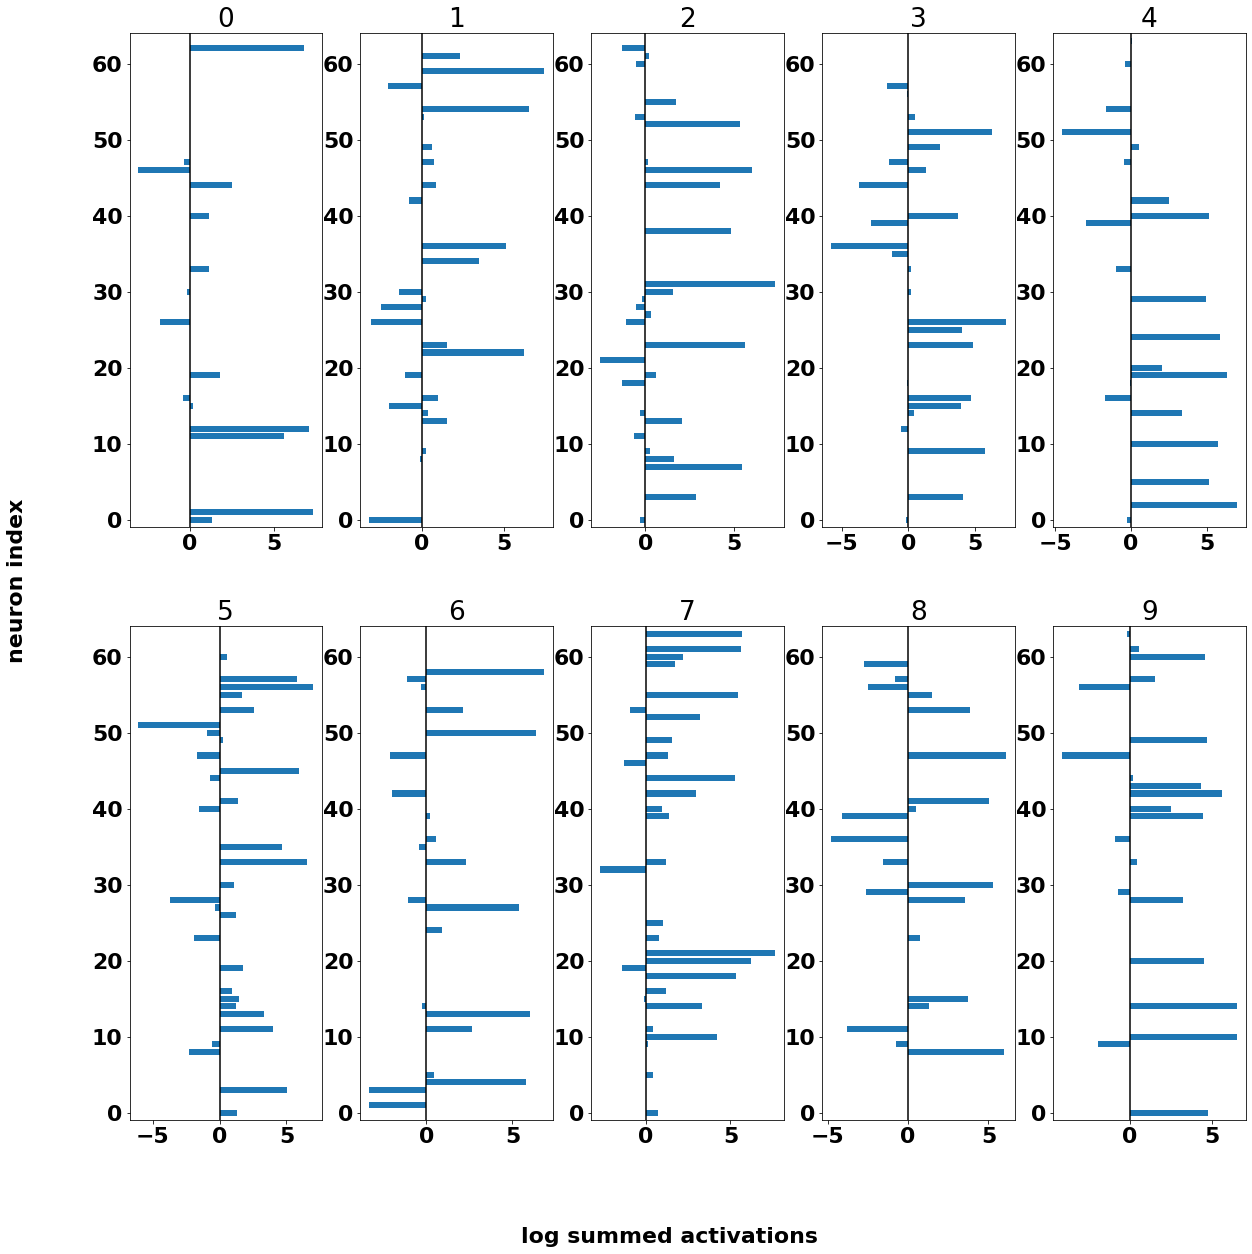

In [21]:
fig = plt.figure(figsize=(20,20))
classes = list(activations_by_class.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(activations_by_class[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(activations_by_class[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(activations_by_class[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(activations_by_class[k])))

fig.text(0.5, 0.04, 'log summed activations', ha='center')
fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### measure degree of polysemantism across training set activations

In [17]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
  a = (np.squeeze(activations_by_class[c[0]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[0]])))) + 1e-9)
  b = (np.squeeze(activations_by_class[c[1]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[1]])))) + 1e-9)
  sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

0.012272926481616903


### visualise hidden neurons

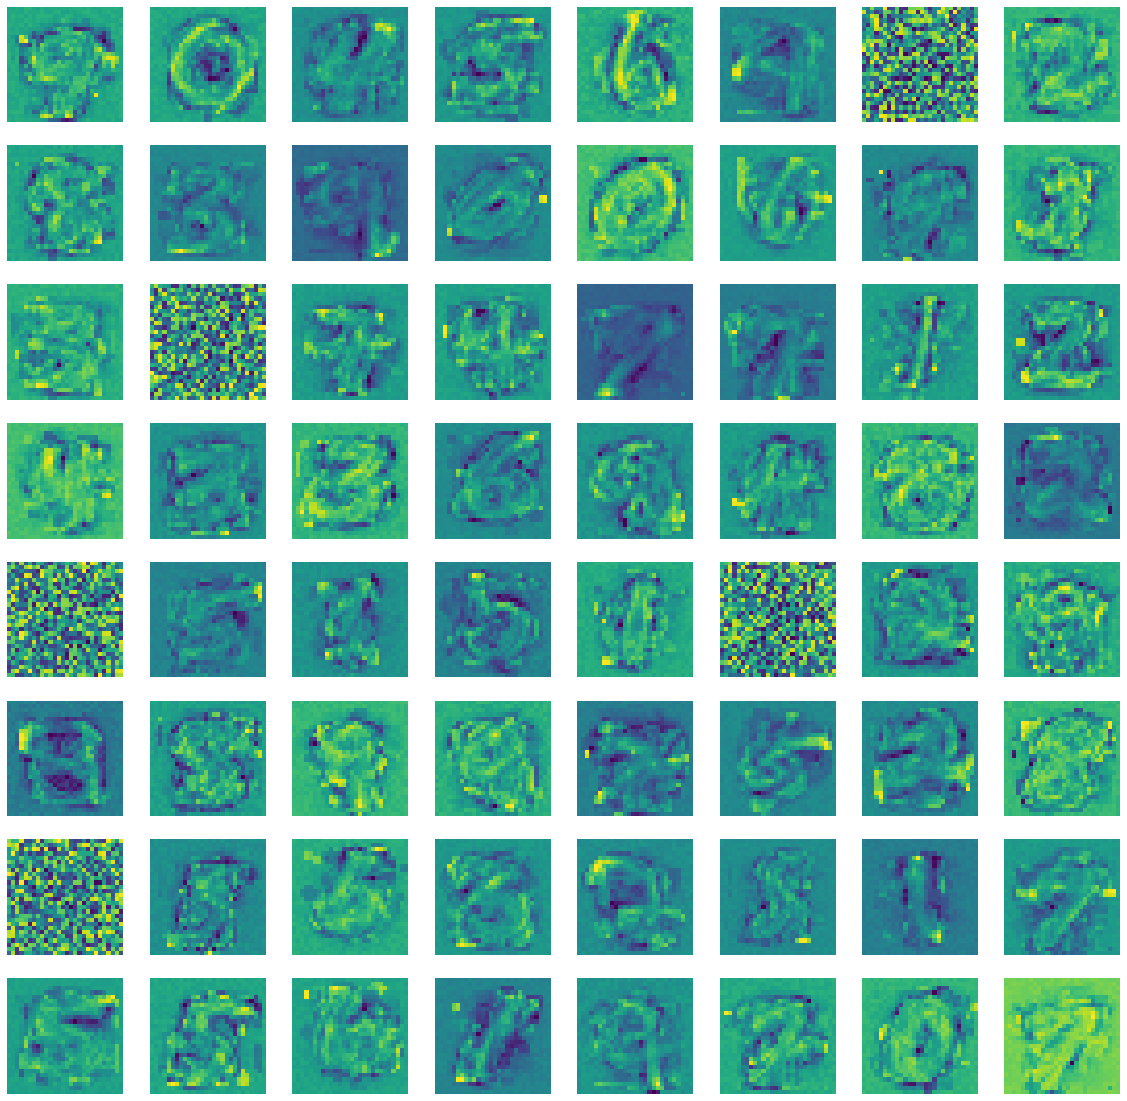

In [23]:
W = embed.layers[1].get_weights()
fig = plt.figure(figsize=(20,20))
dim = int(np.ceil(np.sqrt(n_hidden_neurons)))
for j in range(n_hidden_neurons):
  x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
  ax = fig.add_subplot(dim,dim,j+1)
  #ax.set_title(j+1)
  ax.imshow(x_j.reshape((28,28)))
  plt.axis('off')
plt.show()